# Boston Crime Analysis


In this analysis I will be focusing on the analysis to deduce some predictions and trends in the crime stats.
I will be answering the Following questions:

    Q1. Which are the areas with high crime frequency?
    Q2. Time of the day having highest crime frequency.
    Q3. Is there any trend in the crime frequency?
    Q4. If yes, can predictions be made using this trend?
    Q5. Is it possible to forecast the daily frequency of crimes? How?

In [73]:
#Data_Handling Libraries
import numpy as np
import pandas as pd
import math
from haversine import haversine

#Vizualization Libraries
from matplotlib import style
import matplotlib.pyplot as plt
import seaborn as sns

#jupyter-specific
from ipyleaflet import *

#Algorithm impelentation libraries(Machine Learning)
from scipy.spatial import distance

#Output result settings
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20

%matplotlib inline

### Exploring the Boston-Crime Record Data set

In [2]:
raw_df = pd.read_csv('Data_sets\crime.csv',encoding='latin-1')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319073 entries, 0 to 319072
Data columns (total 17 columns):
INCIDENT_NUMBER        319073 non-null object
OFFENSE_CODE           319073 non-null int64
OFFENSE_CODE_GROUP     319073 non-null object
OFFENSE_DESCRIPTION    319073 non-null object
DISTRICT               317308 non-null object
REPORTING_AREA         319073 non-null object
SHOOTING               1019 non-null object
OCCURRED_ON_DATE       319073 non-null object
YEAR                   319073 non-null int64
MONTH                  319073 non-null int64
DAY_OF_WEEK            319073 non-null object
HOUR                   319073 non-null int64
UCR_PART               318983 non-null object
STREET                 308202 non-null object
Lat                    299074 non-null float64
Long                   299074 non-null float64
Location               319073 non-null object
dtypes: float64(2), int64(4), object(11)
memory usage: 41.4+ MB


In [3]:
# Dropping "INCIDENT_NUMBER"
raw_df.drop("INCIDENT_NUMBER",axis=1, inplace=True)

#Separating 'Date' & 'Time' present in 'OCCURED_ON_DATE' coloumn
raw_df[["DATE","TIME"]] = raw_df['OCCURRED_ON_DATE'].str.split(" ",expand=True) 
raw_df.drop("OCCURRED_ON_DATE", axis=1, inplace=True)
df = raw_df

In [4]:
df.columns

Index(['OFFENSE_CODE', 'OFFENSE_CODE_GROUP', 'OFFENSE_DESCRIPTION', 'DISTRICT',
       'REPORTING_AREA', 'SHOOTING', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR',
       'UCR_PART', 'STREET', 'Lat', 'Long', 'Location', 'DATE', 'TIME'],
      dtype='object')

In [5]:
df

,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location,DATE,TIME
0,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)",2018-09-02,13:00:00
1,1402,Vandalism,VANDALISM,C11,347,NaN,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)",2018-08-21,00:00:00
2,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)",2018-09-03,19:27:00
3,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)",2018-09-03,21:16:00
4,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)",2018-09-03,21:05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319068,3125,Warrant Arrests,WARRANT ARREST,D4,285,NaN,2016,6,Sunday,17,Part Three,COVENTRY ST,42.336951,-71.085748,"(42.33695098, -71.08574813)",2016-06-05,17:25:00
319069,111,Homicide,"MURDER, NON-NEGLIGIENT MANSLAUGHTER",E18,520,NaN,2015,7,Thursday,13,Part One,RIVER ST,42.255926,-71.123172,"(42.25592648, -71.12317207)",2015-07-09,13:38:00
319070,3125,Warrant Arrests,WARRANT ARREST,E18,520,NaN,2015,7,Thursday,13,Part Three,RIVER ST,42.255926,-71.123172,"(42.25592648, -71.12317207)",2015-07-09,13:38:00
319071,3125,Warrant Arrests,WARRANT ARREST,E13,569,NaN,2016,5,Tuesday,19,Part Three,NEW WASHINGTON ST,42.302333,-71.111565,"(42.30233307, -71.11156487)",2016-05-31,19:35:00


Here we have a lot of features or columns in the data set:
        
        'OFFENSE_CODE', 'OFFENSE_CODE_GROUP', 'OFFENSE_DESCRIPTION', 'DISTRICT',
       'REPORTING_AREA', 'SHOOTING', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR',
       'UCR_PART', 'STREET', 'Lat', 'Long', 'Location', 'DATE', 'TIME'

To get a brief knowledge about widespread of the data we will try to plot the data on the boston Map.
            

## Plotting Locations of Reported Crimeson the Map of Boston.

We will be using 'iPyLeafLet' to create an interactive map.

In [122]:
#Extracting geographical location data from the data frame.
location_df = pd.merge(df['Lat'],df['Long'],how='right', right_index=True, left_index=True)
location_df.dropna()

,Lat,Long
0,42.357791,-71.139371
1,42.306821,-71.060300
2,42.346589,-71.072429
3,42.334182,-71.078664
4,42.275365,-71.090361
...,...,...
319068,42.336951,-71.085748
319069,42.255926,-71.123172
319070,42.255926,-71.123172
319071,42.302333,-71.111565


In [123]:
#Generating tuples of Lattitude and Longitude to create markers
locatn_list = []   
for i, j in zip(location_df['Lat'],location_df['Long']):
    if math.isnan(i) or math.isnan(j): pass
    else:
        locatn_list.append((i,j))

In [124]:
#A function to create markers for our Map.
def create_markers(loc_list, n):
    marker_list = []
    for i in loc_list[:n]:
        marker_list.append(Marker(location=i))
    return marker_list

In [125]:
markers = create_markers(locatn_list, 1000)
m = Map(center=[42.3601,-71.0589], zoom=12)
marker_cluster = MarkerCluster(markers=tuple(markers))
m.add_layer(marker_cluster)
m

Map(center=[42.3601, -71.0589], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

##### Here we can observe some outliers present in the data
So we will try to find and remove outliers
(Zoom all out to look for outliers).

# Clustering of Location of Crime
We will be using Kmeans Clustering in order to distribute the reported crimes over the city. To converge the data and find areas area of intreset. Also converging data might produce result that can be useful in future predictions of trends and origin of criminal activities inside city of Boston.

## Kmeans Algorithm
Kmeans algorithm is an iterative algorithm that tries to partition the dataset into Kpre-defined distinct non-overlapping subgroups (clusters) where each data point belongs to only one group. 

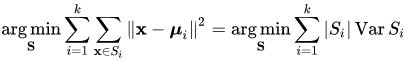


In [126]:
f1 = df['Lat'].values
f1 = f1[~np.isnan(f1)]

f2 = df['Long'].values
f2 = f2[~np.isnan(f2)]

coordinates = np.array(list(zip(f1, f2))) #array to keep Lattidude and Longitude Data

Now we have 299074 locations in total accross the city so, to reduce these data we will try to deduce 10 areas across the city of Boston to simplify our data and continue our analytics.

In [128]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20) #20 clusters covering all the locatiomns accross the city
kmeans = kmeans.fit(coordinates)

In [129]:
#labels = kmeans.predict(coordinates) 
centroids = kmeans.cluster_centers_ #Center coordinates of all the 20 centers
centroids_id = list(dict.fromkeys(kmeans.labels_)) #labels of all the locations

# Plotting the Clusters on the Map

#### Scatter Plot to visualize Clustering on the geo-locations

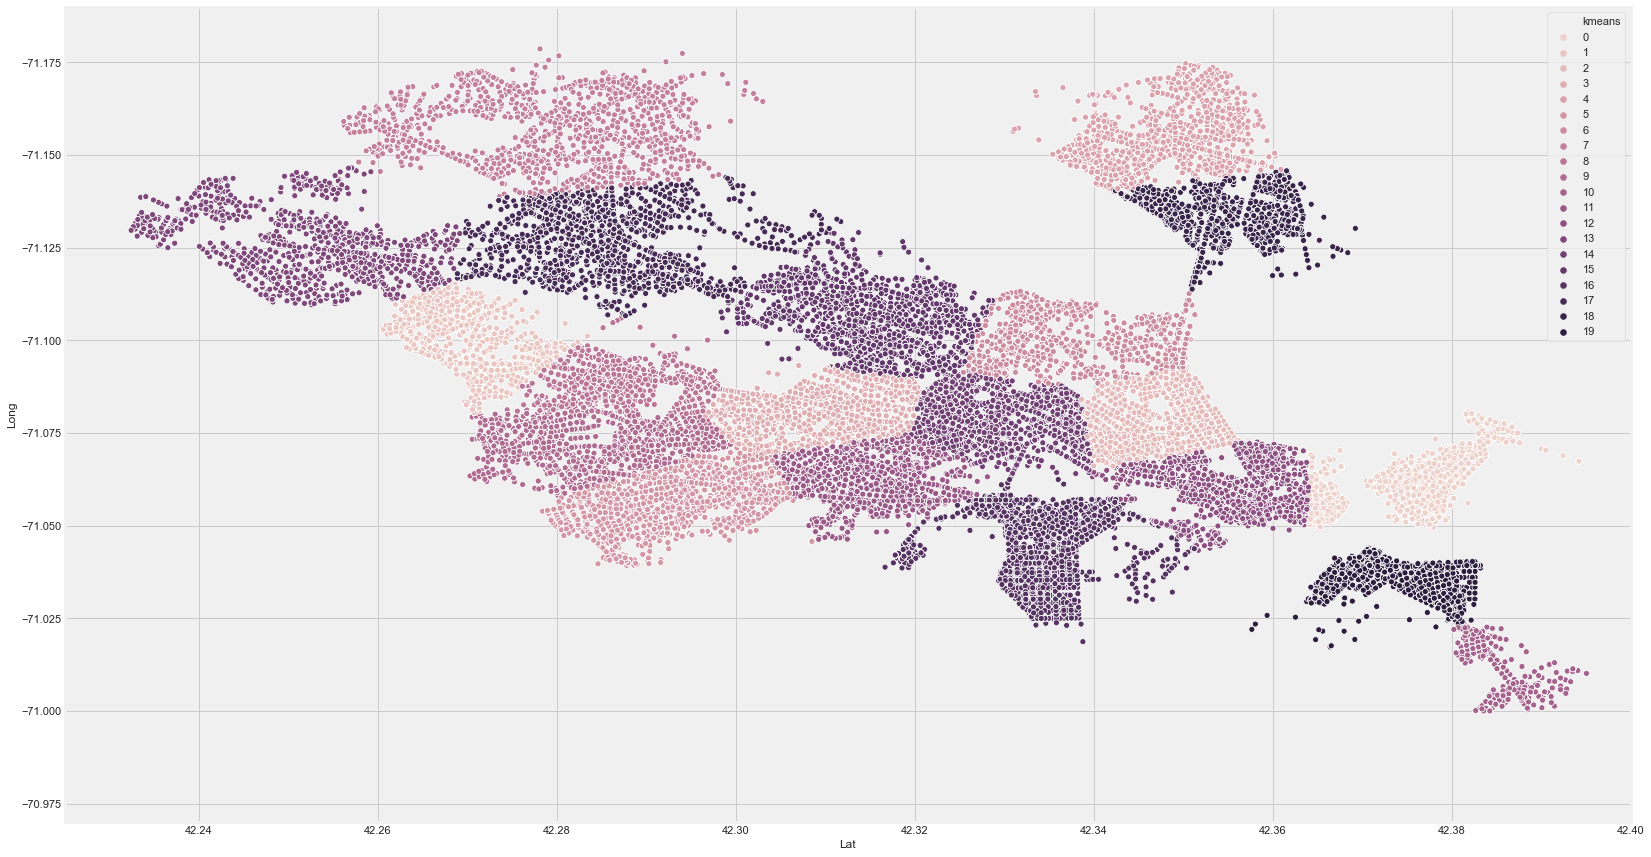

In [130]:
location_df = location_df.dropna()
location_df['kmeans'] = kmeans.labels_
f,ax = plt.subplots(figsize=(25, 15))
plt.xlim((42.225,42.40))
plt.ylim((-70.97, -71.19))
sns.scatterplot(x = 'Lat', y='Long', hue = 'kmeans', data=location_df, ax = ax, legend='full')

We will try now to fit the above 10 clusters as circular areas on the mapto get concerned areas.

In [14]:
# A function to calculate radius of a cluster
def cal_radius(group_df):
    max_dst = 0.0
    
    for i in range(len(group_df)):
        lat, long = group_df['Lat'][i], group_df['Long'][i]
        
        dst = haversine((float(lat),float(long)),tuple(centroids[group_df['kmeans'][i]]))
        
        if max_dst < dst:
            max_dst = dst
            
    return max_dst

In [15]:
radii_list = []
temp_df = location_df.groupby('kmeans')
def grouping():
    for i in centroids_id:
        buffer = (temp_df.get_group(i)).reset_index(drop=True)
        radii_list.append(cal_radius(buffer)*3779575.17575025) #converting Km distance to pixel distance

In [16]:
grouping()

In [17]:
radii_list

[10318652.858219067,
 13353137.766990893,
 15588924.636510687,
 10138315.351118064,
 11238758.266017739,
 11425399.48195297,
 11080651.71121654,
 0.0004954005545215427,
 17474040.376622878,
 31447922.726448134]

In [18]:
#Tools for the interactive map by iPyLeafLet

dc = DrawControl(marker={'shapeOptions': {'color': '#0000FF'}},
                 rectangle={'shapeOptions': {'color': '#0000FF'}},
                 circle={'shapeOptions': {'color': '#0000FF'}},
                 circlemarker={},
                 )

In [19]:
# we will be printing all the actions performed on the map to keep a track
def handle_draw(self, action, geo_json):
    print(action)
    print(geo_json)

dc.on_draw(handle_draw)
m.add_control(dc)

In [131]:
m = Map(center=[42.3601,-71.09], zoom=12, basemap=basemaps.Hydda.Full)

for i,j in zip(centroids,radii_list):
    circle = Circle()
    circle.location = tuple(i)
    circle.radius = int(j/20000)
    circle.color = 'green'
    circle.fill_color='green'
    
    m.add_layer(circle)

m

Map(center=[42.3601, -71.09], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

In [143]:
m = Map(center=[42.3601,-71.09], zoom=12, basemap=basemaps.Hydda.Full)

heatmap = Heatmap(
    locations=center_list,
    radius=100,
    min_opacity = 0.5
)

m.add_layer(heatmap);

m

Map(center=[42.3601, -71.09], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

In [137]:
center_list = []
for i in centroids:
    center_list.append(uniform(list(i)))
center_list

[[42.372767767622356, -71.06066083710613],
 [42.27110187685732, -71.09761527826622],
 [42.3467812501084, -71.07917260139179],
 [42.308738358030155, -71.08083114130088],
 [42.347797728651585, -71.15300127045766],
 [42.29588164875772, -71.05907150883449],
 [42.337518050216076, -71.09917489842428],
 [42.27735736260406, -71.15669568861519],
 [42.287112613103425, -71.08838757148919],
 [42.286586864735376, -71.07241682719324],
 [42.387140839705445, -71.01062961845265],
 [42.31512191664697, -71.06326741185225],
 [42.355263506657614, -71.0609004539872],
 [42.25345887673253, -71.12517221822765],
 [42.33110910705487, -71.0780900265356],
 [42.31638975918828, -71.10330080990343],
 [42.33406181310098, -71.04751384134973],
 [42.28472704587786, -71.12376887632553],
 [42.353488288287316, -71.13298684892203],
 [42.37489974517422, -71.0362037204274]]

In [ ]:
from ipyleaflet import Map, Heatmap
from random import uniform
m = Map(center=(0, 0), zoom=2)

heatmap = Heatmap(
    locations=center,
    radius=20
)

m.add_layer(heatmap);

m

In [139]:
from random import uniform
print([[uniform(-80, 80), uniform(-180, 180), uniform(0, 1000)] for i in range(1000)])

[[-47.37963306386508, -38.18981241939326, 338.7965697197554], [-40.71057938530753, 170.96262516129593, 860.3399027630692], [63.53368060412697, 95.57629136621324, 828.3259623651887], [9.518642720975606, -61.9291681242464, 858.4120471084317], [-26.956820437661655, -131.4118429536435, 439.51562733971105], [70.9888950074234, 153.6827777440589, 845.9655743098042], [-5.227017835382398, 127.51884362985709, 763.4280851270714], [25.03400007153371, -114.68390886150306, 706.9033303617109], [-25.37138763979467, 7.84864327538358, 283.9049169722563], [76.09988013408142, 118.4058468239869, 833.1213227871443], [-39.78242397365609, 100.27203266313415, 270.94628834990885], [31.17388484361757, 131.8081425033743, 717.6954177716511], [-72.68937699527564, -61.84089872027509, 735.9244598507572], [63.89483192834501, 70.09778751479507, 112.43946891580114], [-25.704271845557223, 159.72322582985117, 207.71960592011675], [10.895664254769088, 95.57862495459415, 113.83172135359109], [-26.42138787035396, -38.9774604

## Separating Data on Year-of-Crime bases

In [36]:
year_dict = dict({})
year_list = list(df['YEAR'].unique())
for i in year_list:
    year_dict[i] = []

In [40]:
# storing separated data
for i in year_list:
    temp_df = df['YEAR'] == i
    year_dict[i] = df[temp_df]

In [41]:
#dropping few columns
for i in year_list:
    year_dict[i].drop(["YEAR", "Lat", "Long", "Location"], axis=1, inplace=True)

In [59]:
def yearData(i):
    temp_df = year_dict[i]["DATE"].value_counts()
    return temp_df

2018-06-15    372
2018-05-02    345
2018-05-23    339
2018-06-25    337
2018-05-04    336
             ... 
2018-04-16    199
2018-02-18    190
2018-02-22    190
2018-09-03    176
2018-03-11    174
Name: DATE, Length: 246, dtype: int64

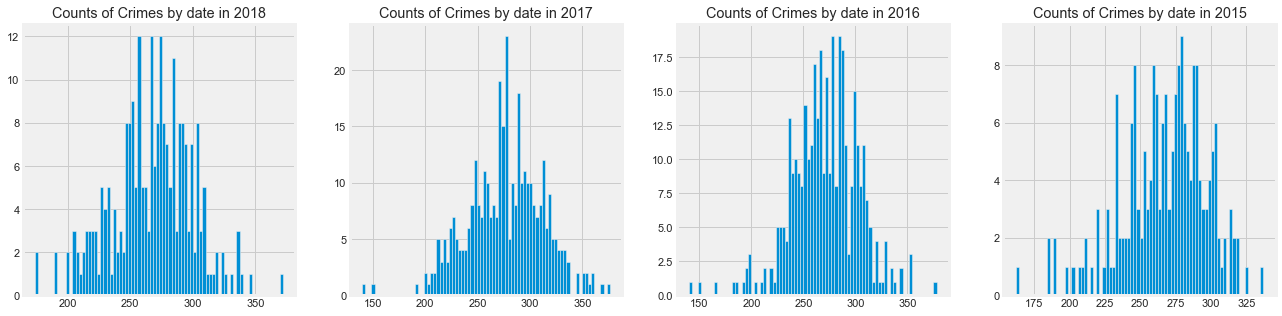

In [79]:
fig = plt.figure(figsize=[20,5])
axes = fig.subplots(1, 4)
for i, j in enumerate(year_list):
    axes[i].hist(year_dict[j]["DATE"].value_counts(), bins=80)
    axes[i].set_title("Counts of Crimes by date in "+str(j))
    
plt.subplots_adjust(wspace=0.2, hspace=0.4)

In [84]:
for i in year_dict:
    temp_df = year_dict[i]["DATE"].value_counts()
    print(str(i)+" :")
    print('skewness is ' + str(temp_df.skew()))
    print('kurtosis is ' + str(temp_df.kurt()))
    print('Mean is ' + str(temp_df.mean()))
    print(" ")

2018 :
skewness is -0.14255789549627598
kurtosis is 0.25779352056577665
Mean is 267.0121951219512
 
2017 :
skewness is -0.2066107839546283
kurtosis is 0.38102517798086977
Mean is 276.4
 
2016 :
skewness is -0.3344916147752683
kurtosis is 1.4020689976133793
Mean is 270.8032786885246
 
2015 :
skewness is -0.6342987303609622
kurtosis is 0.593350207129347
Mean is 266.94
 


The Skewness is negative means that the distribution is left skewed, but not that much.<br>
The kurtosis is greater than 0 means that the peak of the distribution is sharper than a standard normal distribution.

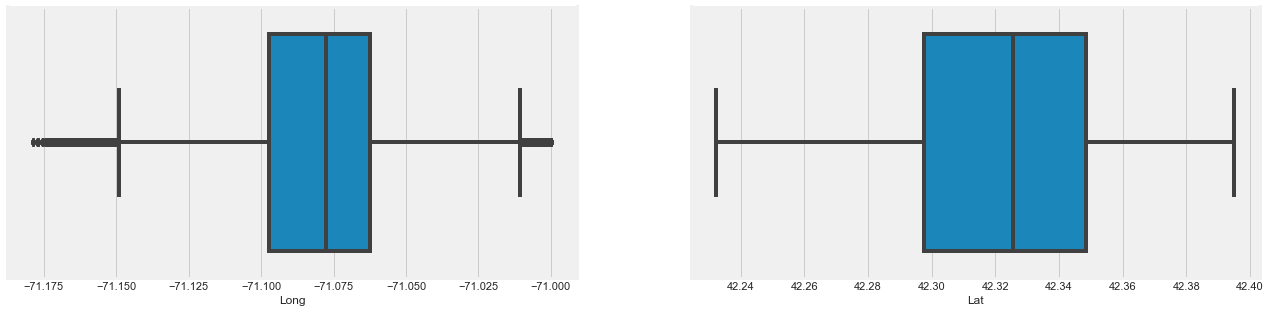

In [116]:
fig = plt.figure(figsize=[20,5])
axes = fig.subplots(1, 2)
sns.boxplot(x=df['Long'], ax=axes[0])
sns.boxplot(x=df['Lat'], ax=axes[1])

In [115]:
df.drop(df[df.Long > -71].index, inplace=True)

In [121]:
df[df["Long"] < -71]

,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location,DATE,TIME
0,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)",2018-09-02,13:00:00
1,1402,Vandalism,VANDALISM,C11,347,NaN,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)",2018-08-21,00:00:00
2,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)",2018-09-03,19:27:00
3,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)",2018-09-03,21:16:00
4,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)",2018-09-03,21:05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319068,3125,Warrant Arrests,WARRANT ARREST,D4,285,NaN,2016,6,Sunday,17,Part Three,COVENTRY ST,42.336951,-71.085748,"(42.33695098, -71.08574813)",2016-06-05,17:25:00
319069,111,Homicide,"MURDER, NON-NEGLIGIENT MANSLAUGHTER",E18,520,NaN,2015,7,Thursday,13,Part One,RIVER ST,42.255926,-71.123172,"(42.25592648, -71.12317207)",2015-07-09,13:38:00
319070,3125,Warrant Arrests,WARRANT ARREST,E18,520,NaN,2015,7,Thursday,13,Part Three,RIVER ST,42.255926,-71.123172,"(42.25592648, -71.12317207)",2015-07-09,13:38:00
319071,3125,Warrant Arrests,WARRANT ARREST,E13,569,NaN,2016,5,Tuesday,19,Part Three,NEW WASHINGTON ST,42.302333,-71.111565,"(42.30233307, -71.11156487)",2016-05-31,19:35:00
